In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

In [ ]:
train_image = []
train_annotation = []

image_file = glob.glob("/content/drive/MyDrive/DatasetYolo/dataset_txt/*.jpg")

for i in image_file:     #slicing for insufficient memory
    Load_image = Image.open(i).convert('RGB')
    nmpy_img = Load_image.resize((256, 256))
    train_image.append(np.asarray(nmpy_img))

    seperate_path = i.split('.')
    seperate_path[1] = '.txt'

    with open(seperate_path[0]+seperate_path[1]) as f:
        lines = f.readlines()
        tmp_lst = lines[0].split(' ')
        #label = int(tmp_lst[0])
        startX = float(tmp_lst[1])
        startY = float(tmp_lst[2])
        endX = float(tmp_lst[3])
        endY = float(tmp_lst[4])
        train_annotation.append((startX, startY, endX, endY))

1359


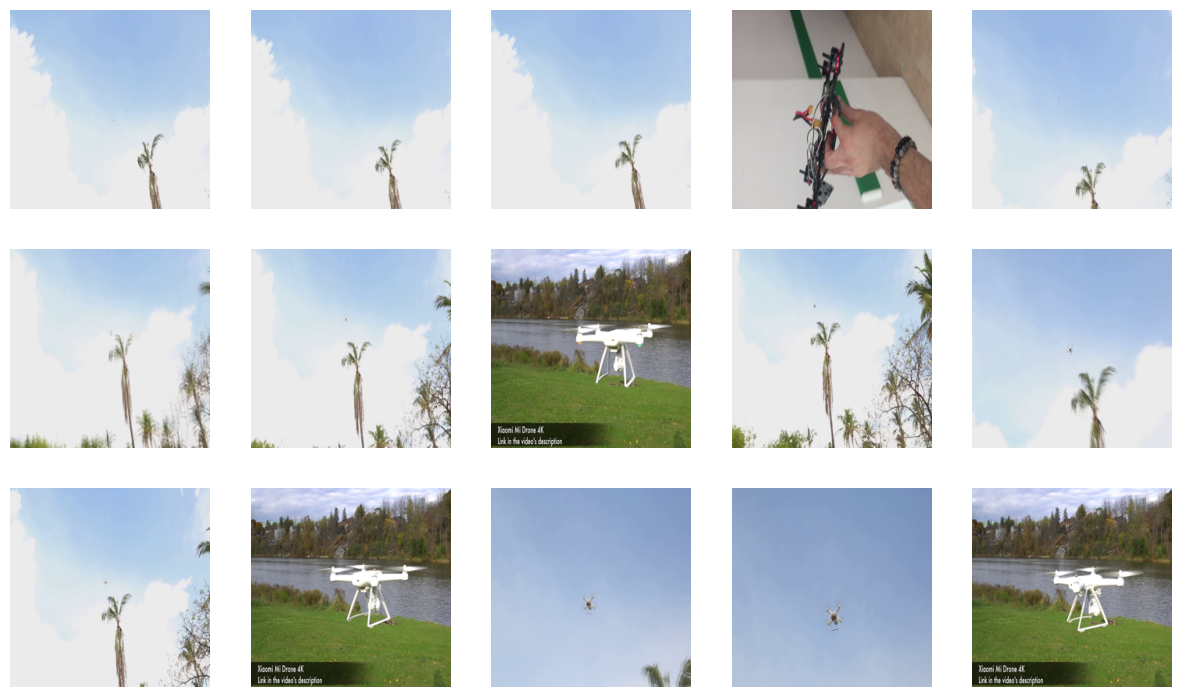

In [ ]:
print(len(train_image))

plt.figure(figsize=(15, 15))

for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [ ]:
from sklearn.model_selection import train_test_split
data = np.array(train_image, dtype='float32') / 255.0   # memory not sufficient !!
targets = np.array(train_annotation, dtype='float32')

split = train_test_split(data, targets, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

# Printing the shapes of the data and targets arrays

data.shape, targets.shape

((1359, 256, 256, 3), (1359, 4))

In [ ]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras import Model,Input

def build_vggmodel():
    vgg = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    vgg.trainable = True

    flatten = vgg.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    vggmodel = Model(inputs=vgg.input, outputs=bboxHead)

    return vggmodel

vggmodel = build_vggmodel()

vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
vggmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("VGGModel.h5",monitor='val_loss',save_best_only=True, verbose=1)

historyvgg= vggmodel.fit(
    trainImages,
    trainTargets,
    validation_split=0.2,
    batch_size= 5,
    epochs=3,
    verbose=1,
    callbacks=[save_best]
)

Epoch 1/3
196/196 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.5808 
Epoch 1: val_loss improved from inf to 0.04955, saving model to VGGModel.h5
196/196 [==============================] - 2778s 14s/step - loss: 0.4588 - accuracy: 0.5808 - val_loss: 0.0495 - val_accuracy: 0.6245
Epoch 2/3
196/196 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.6421 
Epoch 2: val_loss improved from 0.04955 to 0.04551, saving model to VGGModel.h5
196/196 [==============================] - 2660s 14s/step - loss: 0.0418 - accuracy: 0.6421 - val_loss: 0.0455 - val_accuracy: 0.6245
Epoch 3/3
196/196 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.6421 
Epoch 3: val_loss did not improve from 0.04551
196/196 [==============================] - 2707s 14s/step - loss: 0.0379 - accuracy: 0.6421 - val_loss: 0.0456 - val_accuracy: 0.6245


In [ ]:
vggmodel = tf.keras.models.load_model('VGGModel.h5')

vggmodel.predict(testImages[:10], verbose=1)

1/1 [==============================] - 8s 8s/step


array([[0.45218372, 0.37688246, 0.54746485, 0.41765997],
       [0.48116782, 0.40118217, 0.58547723, 0.4455667 ],
       [0.39157873, 0.3260408 , 0.46793252, 0.35930133],
       [0.38169408, 0.3177561 , 0.45497262, 0.34978467],
       [0.48519033, 0.40457746, 0.5907886 , 0.44944447],
       [0.48160297, 0.40154684, 0.5860479 , 0.4459857 ],
       [0.42600504, 0.35491896, 0.51310706, 0.39245117],
       [0.41607922, 0.3465463 , 0.50000983, 0.38288367],
       [0.48117775, 0.40119028, 0.58549017, 0.44557613],
       [0.39555427, 0.32937598, 0.47315   , 0.3631295 ]], dtype=float32)

Final Training Accuracy: 0.6421267986297607
Final Validation Accuracy: 0.6244897842407227


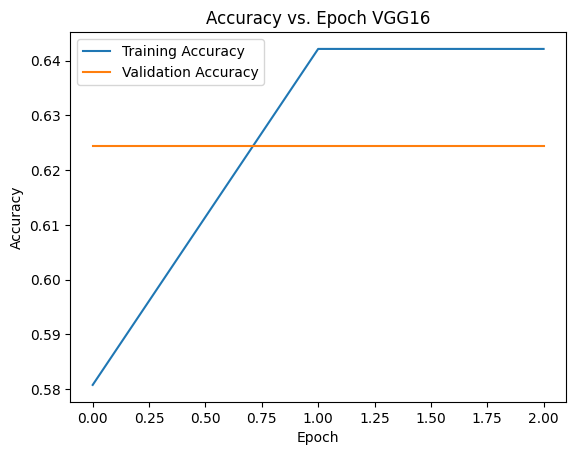

In [ ]:
print('Final Training Accuracy:', historyvgg.history['accuracy'][-1])
print('Final Validation Accuracy:', historyvgg.history['val_accuracy'][-1])

plt.plot(historyvgg.history['accuracy'], label='Training Accuracy')
plt.plot(historyvgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch VGG16')
plt.legend()
plt.show()

Final Training Loss: 0.03791803866624832
Final Validation Loss: 0.04558896645903587


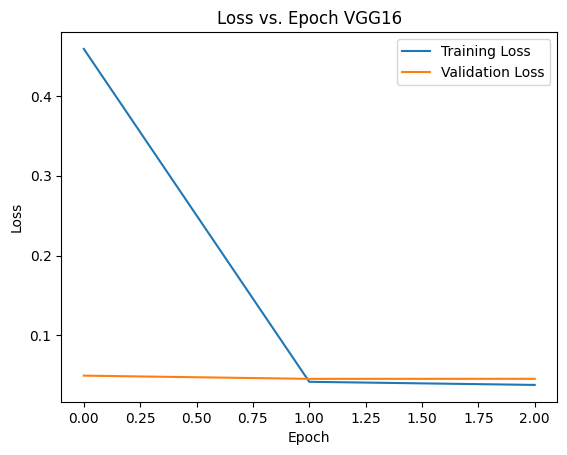

In [ ]:
print('Final Training Loss:', historyvgg.history['loss'][-1])
print('Final Validation Loss:', historyvgg.history['val_loss'][-1])

plt.plot(historyvgg.history['loss'], label='Training Loss')
plt.plot(historyvgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch VGG16')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = vggmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 103s 19s/step - loss: 0.0370 - accuracy: 0.6324
Test Loss: 0.03699783235788345
Test Accuracy: 0.6323529481887817


In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model, Input

def build_resnetmodel():
    resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

    resnet.trainable = True

    flatten = resnet.output
    flatten = Flatten()(flatten)

    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxHead = Dense(4, activation="linear")(bboxHead)

    resnetmodel = Model(inputs=resnet.input, outputs=bboxHead)

    return resnetmodel

resnetmodel = build_resnetmodel()

resnetmodel.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
resnetmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

save_best = tf.keras.callbacks.ModelCheckpoint("RESNETModel.h5", verbose=1)

historyresnet= resnetmodel.fit(
    trainImages, trainTargets,
    validation_split=0.2,
    batch_size= 3,
    epochs=3,
    verbose=1,
    callbacks=[save_best])

Epoch 1/3
326/326 [==============================] - ETA: 0s - loss: 0.7341 - accuracy: 0.4796
Epoch 1: saving model to RESNETModel.h5
326/326 [==============================] - 1181s 4s/step - loss: 0.7341 - accuracy: 0.4796 - val_loss: 0.1374 - val_accuracy: 0.1510
Epoch 2/3
326/326 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.6575
Epoch 2: saving model to RESNETModel.h5
326/326 [==============================] - 1118s 3s/step - loss: 0.0287 - accuracy: 0.6575 - val_loss: 0.0548 - val_accuracy: 0.2041
Epoch 3/3
326/326 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.7403
Epoch 3: saving model to RESNETModel.h5
326/326 [==============================] - 1126s 3s/step - loss: 0.0196 - accuracy: 0.7403 - val_loss: 0.0290 - val_accuracy: 0.6041


In [ ]:
resnetmodel = tf.keras.models.load_model('./RESNETModel.h5')

resnetmodel.predict(testImages[:10], verbose=1)

1/1 [==============================] - 5s 5s/step


array([[0.5117347 , 0.41326025, 0.68282187, 0.5739335 ],
       [0.5033157 , 0.40611306, 0.8441263 , 0.5597048 ],
       [0.50539666, 0.47746637, 0.45870456, 0.39779994],
       [0.69053274, 0.6329435 , 0.60071576, 0.55399156],
       [0.41780233, 0.28968403, 0.47115308, 0.448625  ],
       [0.4533689 , 0.3245839 , 0.72910595, 0.5600879 ],
       [0.60906774, 0.5228792 , 0.46660277, 0.39090422],
       [0.51766944, 0.38157007, 0.6537335 , 0.50715303],
       [0.5434636 , 0.3326363 , 0.7485157 , 0.52039003],
       [0.6100142 , 0.45933437, 0.54247195, 0.4949015 ]], dtype=float32)

In [ ]:
print('Final Training Accuracy:', historyresnet.history['accuracy'][-1])
print('Final Validation Accuracy:', historyresnet.history['val_accuracy'][-1])

plt.plot(historyresnet.history['accuracy'], label='Training Accuracy')
plt.plot(historyresnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch RESNET50')
plt.legend()
plt.show()

Final Training Loss: 0.019626740366220474
Final Validation Loss: 0.02895069494843483


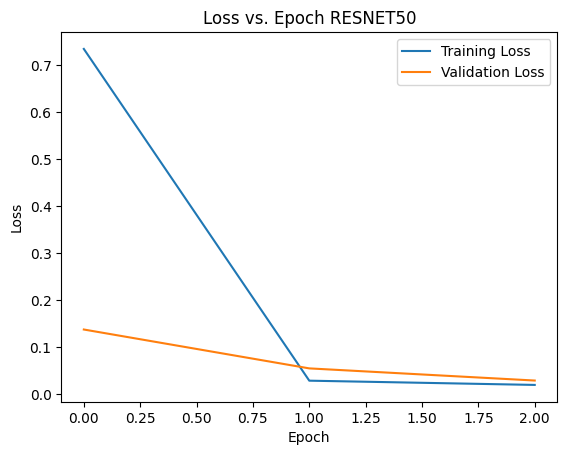

In [ ]:
print('Final Training Loss:', historyresnet.history['loss'][-1])
print('Final Validation Loss:', historyresnet.history['val_loss'][-1])

plt.plot(historyresnet.history['loss'], label='Training Loss')
plt.plot(historyresnet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch RESNET50')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = resnetmodel.evaluate(testImages, testTargets, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 [==============================] - 34s 6s/step - loss: 0.0208 - accuracy: 0.5662
Test Loss: 0.020807789638638496
Test Accuracy: 0.5661764740943909


In [ ]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 633.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 549.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 973.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 935.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
import shutil
from tqdm import tqdm

DATA_DIR = "/content/drive/MyDrive/DatasetYolo/dataset_txt"

images = []
labels = []
image_paths = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

for image_path in tqdm(image_paths):     #slicing for insufficient memory
    images.append(image_path)
    label_path = image_path.split('.')[0] + '.txt'
    labels.append(label_path)

100%|██████████| 1359/1359 [00:00<00:00, 593261.78it/s]


In [ ]:
from sklearn.model_selection import train_test_split
split = train_test_split(images, labels, test_size=0.10, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

In [ ]:
TRAIN_IMAGE_DIR = 'train/images'
TRAIN_LABEL_DIR = 'train/labels'
VAL_IMAGE_DIR = 'valid/images'
VAL_LABEL_DIR = 'valid/labels'

os.makedirs(TRAIN_IMAGE_DIR, exist_ok=True)
os.makedirs(TRAIN_LABEL_DIR, exist_ok=True)

os.makedirs(VAL_IMAGE_DIR, exist_ok=True)
os.makedirs(VAL_LABEL_DIR, exist_ok=True)

for path in tqdm(trainImages):
    shutil.copyfile(path, os.path.join(TRAIN_IMAGE_DIR, os.path.basename(path)))

for path in tqdm(testImages):
    shutil.copyfile(path, os.path.join(VAL_IMAGE_DIR, os.path.basename(path)))

for path in tqdm(trainTargets):
    shutil.copyfile(path, os.path.join(TRAIN_LABEL_DIR, os.path.basename(path)))

for path in tqdm(testTargets):
    shutil.copyfile(path, os.path.join(VAL_LABEL_DIR, os.path.basename(path)))

100%|██████████| 136/136 [00:00<00:00, 255.29it/s]


In [ ]:
%%writefile drone.yaml

path: /content/drive/MyDrive/DatasetYolo/dataset_txt
train: /content/train
val: /content/valid

nc: 1

# Classes
names: ['drone']

Overwriting drone.yaml


In [ ]:
# Disable wandb
import os
os.environ['WANDB_DISABLED'] = 'true'

In [ ]:
from ultralytics import YOLO
# Load a model
model = YOLO("yolov8s.yaml")  # build a new model from scratch
model = YOLO("yolov8s.pt")  # load a pretrained model (recommended for training)

In [ ]:
# Use the model
results = model.train(
   data='drone.yaml',
   imgsz=256,
   epochs=5,
   batch=8,
   name='yolov8s_v8_50e'
)  # train the model

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=drone.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_v8_50e6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /content/train/labels.cache... 1223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1223/1223 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/train/images/pic_722.jpg: corrupt JPEG restored and saved
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_v8_50e6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8s_v8_50e6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.401      1.207       1.35         21        256: 100%|██████████| 153/153 [08:04<00:00,  3.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.10s/it]

                   all        136        148      0.469      0.655      0.518      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.576      1.313      1.468         25        256: 100%|██████████| 153/153 [07:59<00:00,  3.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.08s/it]

                   all        136        148      0.594      0.655      0.634      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.491      1.245      1.432         18        256: 100%|██████████| 153/153 [07:53<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:17<00:00,  1.98s/it]

                   all        136        148      0.807      0.716      0.794       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.432      1.139      1.385         16        256: 100%|██████████| 153/153 [07:56<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]

                   all        136        148      0.874      0.748      0.847       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.371      1.043      1.329         22        256: 100%|██████████| 153/153 [07:54<00:00,  3.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:17<00:00,  1.99s/it]

                   all        136        148      0.938      0.812      0.908      0.577



5 epochs completed in 0.694 hours.
Optimizer stripped from runs/detect/yolov8s_v8_50e6/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_v8_50e6/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_v8_50e6/weights/best.pt...
Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:19<00:00,  2.12s/it]


                   all        136        148      0.938      0.812      0.909      0.577
Speed: 0.5ms preprocess, 102.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/yolov8s_v8_50e6


In [ ]:
import math
import random

# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=None, num_cols=1):
    """
    Function accepts a list of images and plots
    """
    image_names = sorted(glob.glob(os.path.join(result_dir, '*.jpg')))

    if num_samples is not None:
        image_names = random.sample(image_names, num_samples)

    num_images = len(image_names)
    num_rows = int(math.ceil(num_images / num_cols))
    plt.figure(figsize=(12 * num_cols, 6 * num_rows))

    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize('runs/detect/yolov8s_v8_50e', num_cols=1)

<Figure size 1200x0 with 0 Axes>


image 1/1 /content/drive/MyDrive/DatasetYolo/dataset_txt/0001.jpg: 128x256 4 drones, 83.5ms
Speed: 0.8ms preprocess, 83.5ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 256)

image 1/136 /content/valid/images/0005.jpg: 192x256 (no detections), 115.2ms
image 2/136 /content/valid/images/0024.jpg: 256x256 1 drone, 109.7ms
image 3/136 /content/valid/images/0028.jpg: 192x256 1 drone, 114.7ms
image 4/136 /content/valid/images/0033.jpg: 160x256 1 drone, 144.4ms
image 5/136 /content/valid/images/0042.jpg: 192x256 1 drone, 144.0ms
image 6/136 /content/valid/images/0059.jpg: 160x256 1 drone, 121.0ms
image 7/136 /content/valid/images/0061.jpg: 192x256 1 drone, 140.0ms
image 8/136 /content/valid/images/0082.jpg: 256x256 1 drone, 184.8ms
image 9/136 /content/valid/images/0216.jpg: 160x256 1 drone, 121.5ms
image 10/136 /content/valid/images/0227.jpg: 128x256 1 drone, 100.4ms
image 11/136 /content/valid/images/0242.jpg: 256x256 2 drones, 186.9ms
image 12/136 /content/valid/images/0256

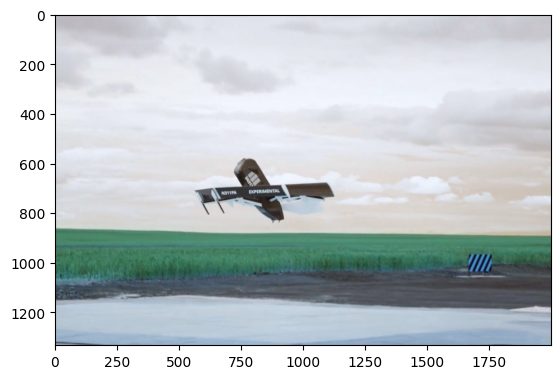

In [ ]:
results = model("/content/drive/MyDrive/DatasetYolo/dataset_txt/0001.jpg", conf=0.5, agnostic_nms=True, iou=0.5)  # predict on an image
results = model("valid/images", conf=0.5, agnostic_nms=True, iou=0.5, save=True)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
plt.show()

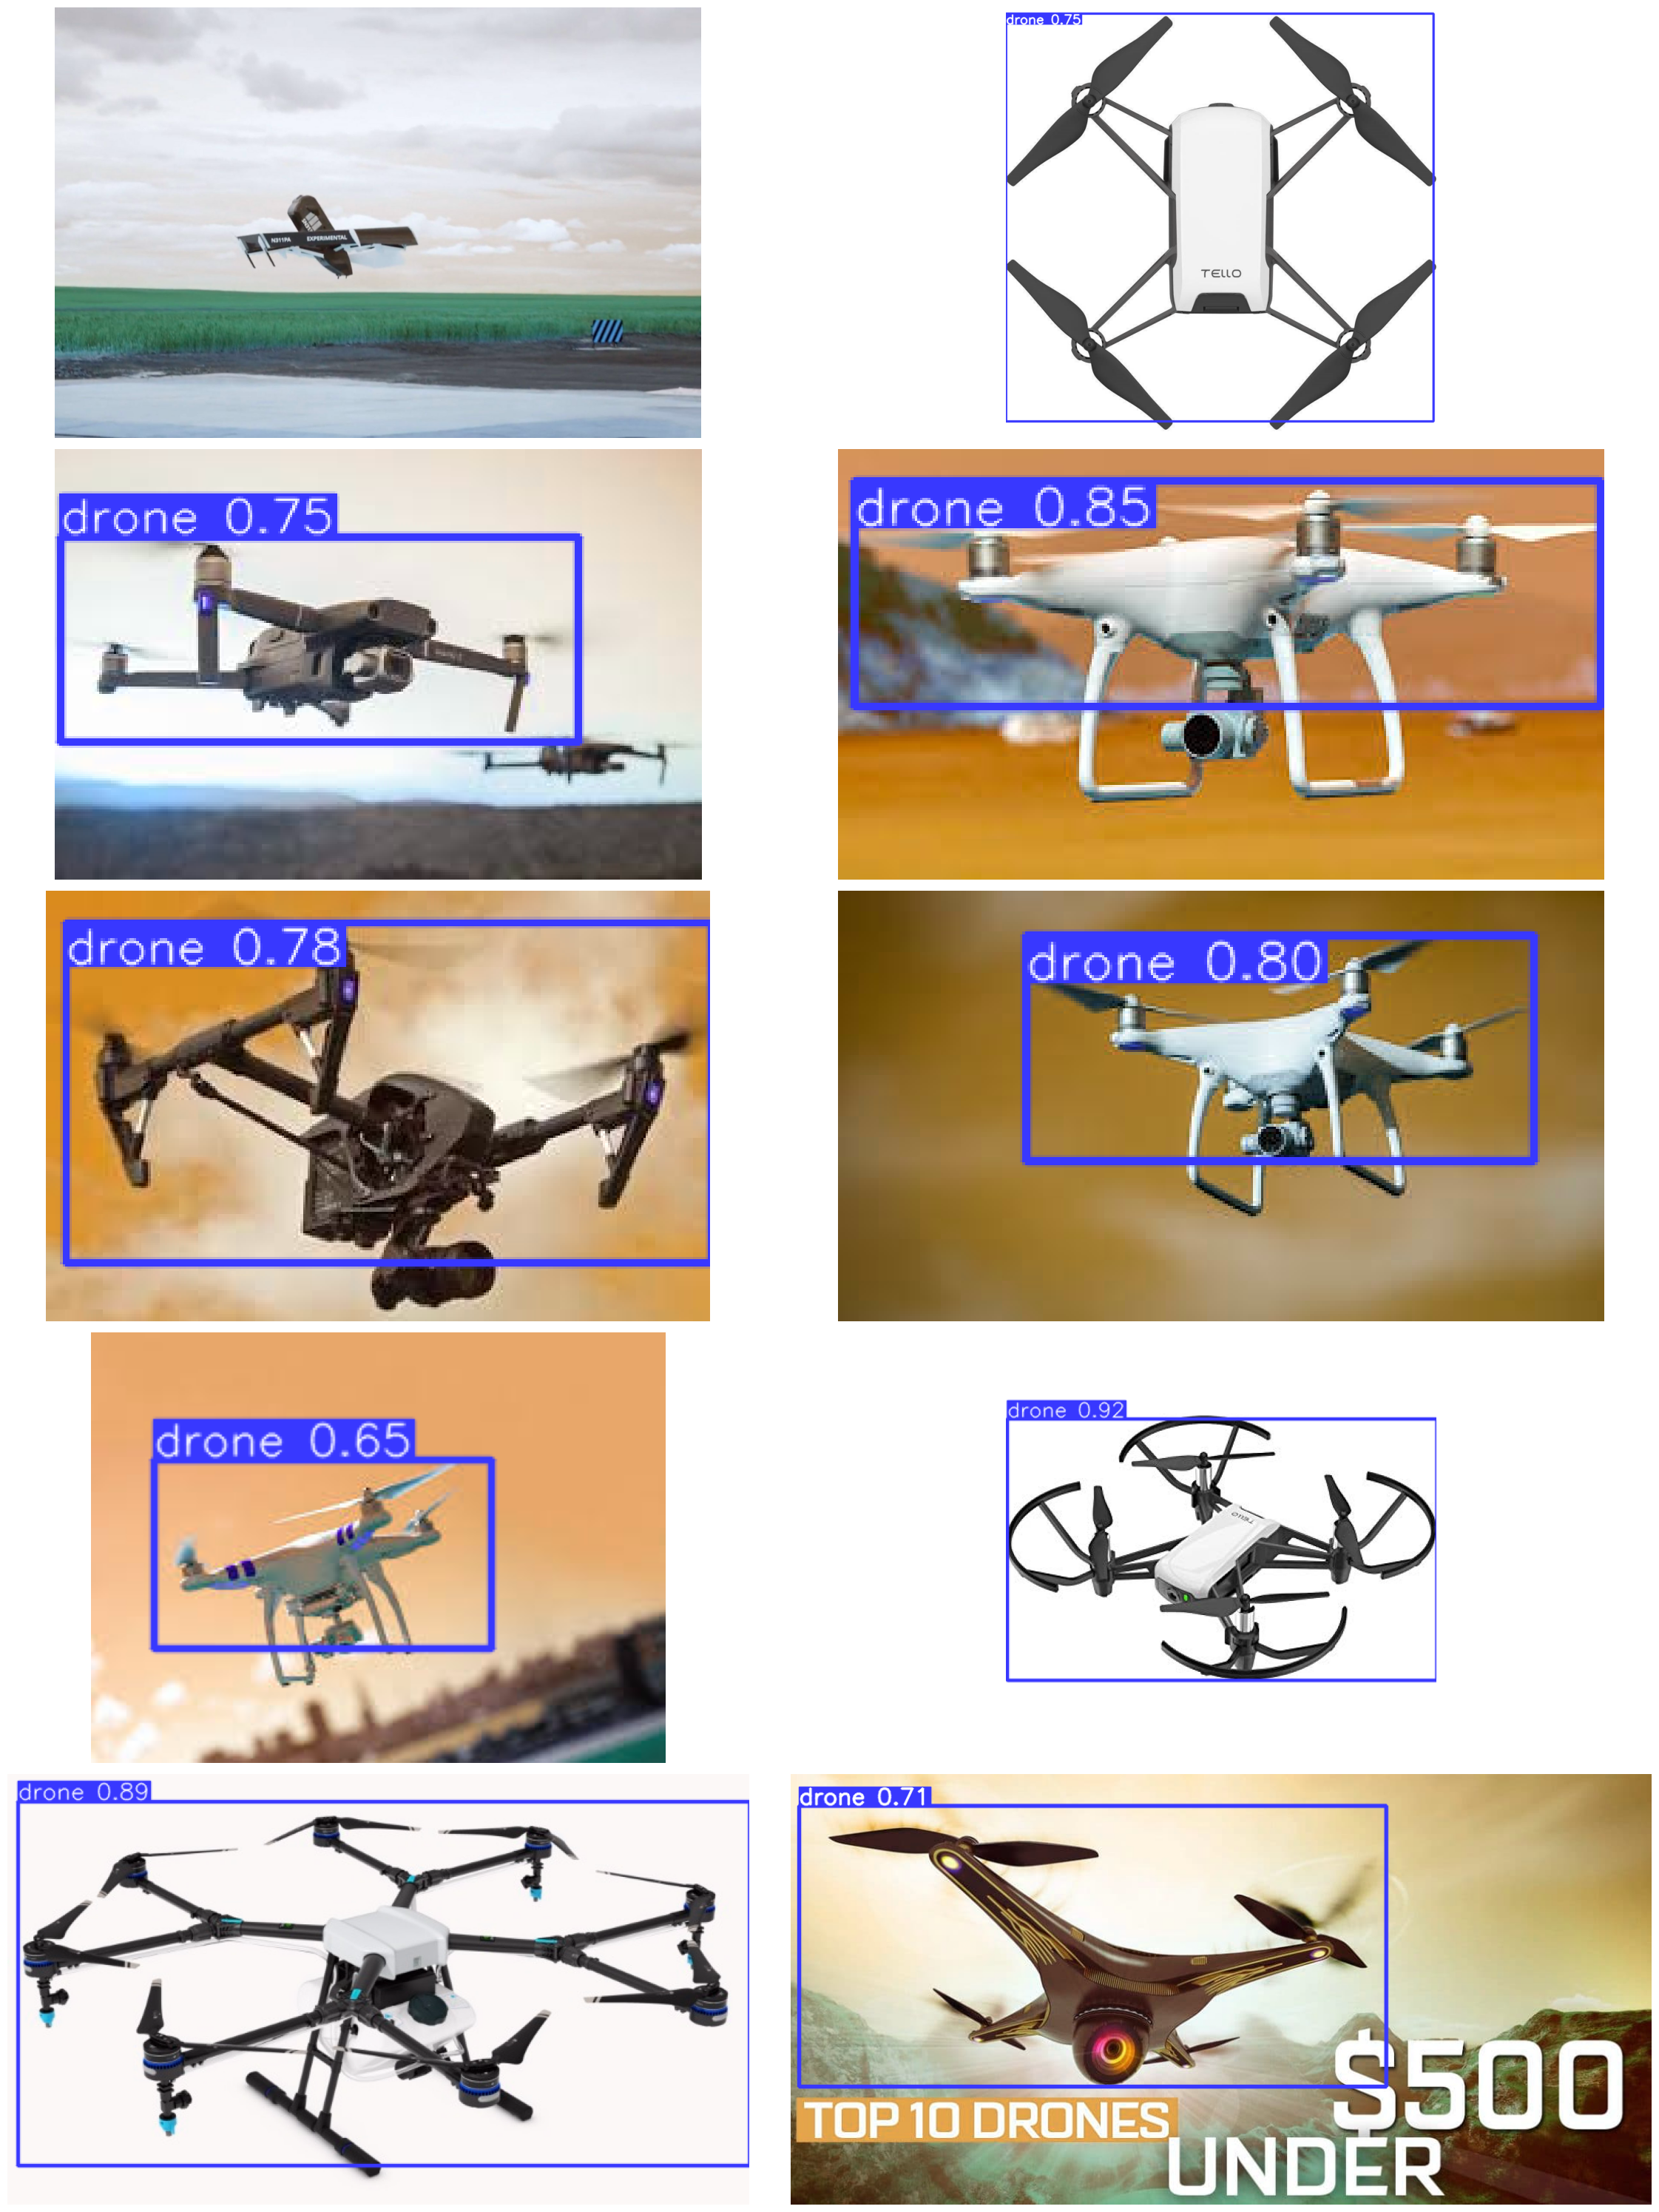

In [ ]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))

for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
success = model.export(format="onnx")  # export the model to ONNX format
success

Ultralytics YOLOv8.2.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

PyTorch: starting from 'yolov8s.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 95.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 14.6s, saved as 'yolov8s.onnx' (42.8 MB)

Export complete (17.8s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8s.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8s.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov8s.onnx'